## <center> **Plant Seedlings Classification** </center>




In [1]:
tensorflow_version 2.x

TensorFlow 2.x selected.


**Import necessary packages:**

In [2]:
import tensorflow as tf
print(tf.__version__)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

2.1.0-rc1


**Mount Drive:**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Define paths:**

In [0]:
base_data_folder = "/content/drive/My Drive/CNN/plant-seedlings-classification"

In [0]:
train_data_folder = os.path.join(base_data_folder, "train")

**Get the classifications from the sub folder names:**

In [12]:
categories = os.listdir(train_data_folder)
categories

['Shepherds Purse',
 'Scentless Mayweed',
 'Sugar beet',
 'Maize',
 'Loose Silky-bent',
 'Small-flowered Cranesbill',
 'Common wheat',
 'Fat Hen',
 'Common Chickweed',
 'Cleavers',
 'Charlock',
 'Black-grass']

**Get count of images under each label:**

In [13]:
plants_df = pd.DataFrame(columns=('Plant_Species_name','Count'))

for category in categories:
  class_folder_path = os.path.join(train_data_folder, category)
  count = len([cnt for cnt in os.scandir(class_folder_path)])
  plants_df = plants_df.append({'Plant_Species_name': category, 'Count': count}, ignore_index=True)

plants_df

,Plant_Species_name,Count
0,Shepherds Purse,231
1,Scentless Mayweed,516
2,Sugar beet,385
3,Maize,221
4,Loose Silky-bent,654
5,Small-flowered Cranesbill,496
6,Common wheat,221
7,Fat Hen,475
8,Common Chickweed,611
9,Cleavers,287


## **Create image mask:**

**Create mask:**

In [0]:
def create_mask_for_plant(image):
    # Convert image to HSV
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Set boundaries to detect green color
    lower_hsv = np.array([25, 100, 5])
    upper_hsv = np.array([95, 255, 255])

    # Apply inRange method which returns a mask, specifying which pixels fall into your specified upper and lower range.
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    # Using elliptical structuring element
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13,13)) 
    # Using morph_close: Dilation followed by Erosion. It is useful in closing small holes inside the foreground objects, or small black points on the object. 
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)          
    return mask

**bitwise_and operation:**

In [0]:
def segment_plant(image):
    mask = create_mask_for_plant(image)
    # Calculates the per-element bit-wise conjunction of two arrays or an array and a scalar.
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

**Sharpen image:**

In [0]:
def sharpen_image(image):
    # Blur the image
    blur = cv2.GaussianBlur(image, (5,5), 0)
    # Get the weighted sum of original and blurred images
    sharpen = cv2.addWeighted(image, 1.5, blur, -0.5, 0 )
    return sharpen

## **View an image in train data:**

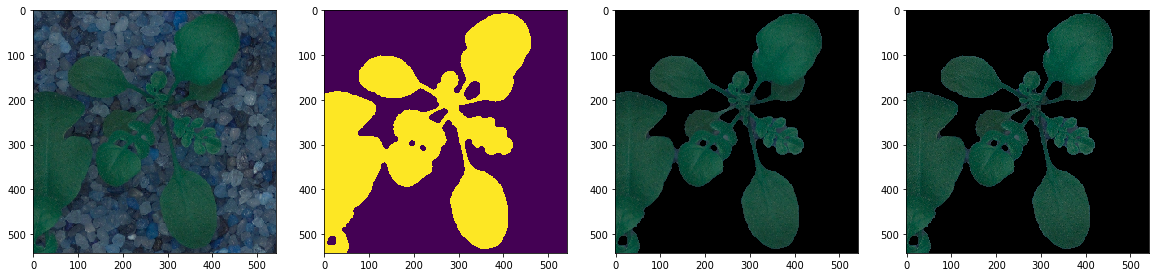

In [0]:
img = cv2.imread('/content/drive/My Drive/CNN/plant-seedlings-classification/train/Shepherds Purse/0bef4ae08.png', 1)
image_mask = create_mask_for_plant(img)                   
image_segmented = segment_plant(img)  
image_sharpen = sharpen_image(image_segmented) 

fig, axs = plt.subplots(1, 4, figsize=(20, 20))
axs[0].imshow(img)
axs[1].imshow(image_mask)
axs[2].imshow(image_segmented)
axs[3].imshow(image_sharpen)


## **Load images from train data and perform necessary preprocessing:**

In [0]:
training_data = []
img_size = 100

def create_training_data():
  for category in os.listdir(train_data_folder):
    class_folder_path = os.path.join(train_data_folder, category)
    class_num = categories.index(category)

    for img in os.listdir(class_folder_path):
      try:
        img_array = cv2.imread(os.path.join(class_folder_path, img), cv2.IMREAD_COLOR)  # image read
        new_array = cv2.resize(img_array, (img_size, img_size))                         # Resize images so as to be consistent
        image_segmented = segment_plant(new_array)                                      # Apply mask to remove background noise
        image_sharpen = sharpen_image(image_segmented)                                  # Sharpen the image
        training_data.append([image_sharpen, class_num])                                # Create train data with label
      except Exception as e:
        pass

In [0]:
create_training_data()

**Number of images in training data:**

In [0]:
print(len(training_data))

4750


## **Shuffle the data:**

We shuffle the data so that similar plant species (labels) in the data is not grouped together

In [0]:
# Labels before shuffling:
for sample in training_data[:10]:
  print(sample[1])

0
0
0
0
0
0
0
0
0
0


In [0]:
# Shuffle training data:
random.shuffle(training_data)

In [0]:
# Labels after shuffling:
for sample in training_data[:10]:
  print(sample[1])

2
7
2
10
8
8
8
10
4
8


## **Create train data and their corresponding labels**

In [0]:
X = []
y = []

In [0]:
for features, label in training_data:
  X.append(features)
  y.append(label)

In [0]:
X = np.array(X).reshape(-1, img_size, img_size, 3)

## **Save data in pickle file:**

In [0]:
pickle_out = open("/content/drive/My Drive/CNN/plant-seedlings-classification/X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/CNN/plant-seedlings-classification/y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

## **Retrieve data from pickle file:**

In [0]:
# pickle_in = open("/content/drive/My Drive/CNN/plant-seedlings-classification/X.pickle", "rb")
# X = pickle.load(pickle_in)

# pickle_in = open("/content/drive/My Drive/CNN/plant-seedlings-classification/y.pickle", "rb")
# y = pickle.load(pickle_in)

### **Get the count of unique classes in the data:**

In [5]:
num_classes = len(np.unique(y))
num_classes

12

## **Convert classes to categorical:**

In [6]:
print(y[10])
y = tf.keras.utils.to_categorical(y, num_classes=num_classes)
print(y[10])

5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


## **Pie Chart representation of data under each label:**

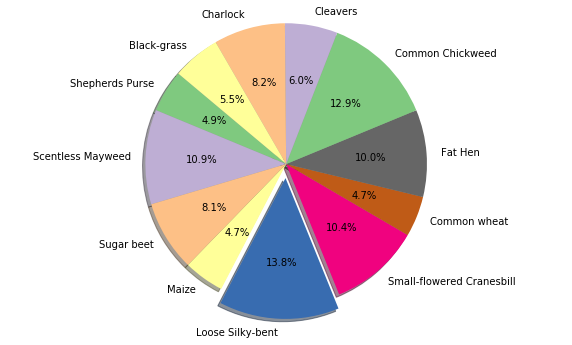

In [0]:
plt.subplots(figsize=(10,6))

explode = (0, 0, 0, 0, 0.1, 0, 0, 0, 0, 0, 0, 0) 
plt.pie(plants_df['Count'].values, explode=explode, labels=plants_df['Plant_Species_name'], colors=sns.color_palette('Accent',20),
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

## **Normalize the data:**

In [0]:
X = X/255

## **Split data into train and test:**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)

## **Check the shape of train and test data:**

**Shape of train data:**

In [0]:
X_train.shape

(4275, 100, 100, 3)

**Shape of test data:**

In [9]:
X_test.shape

(475, 100, 100, 3)

## **Generate images using Image Data Generator:**

In [0]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range = 180,
      zoom_range = 0.1,
      width_shift_range = 0.1,
      height_shift_range = 0.1,
      horizontal_flip = True,
      vertical_flip = True)

# Fit the data:
generator.fit(X_train)

## **Build Model:**

**Let's view an image before building the model:**

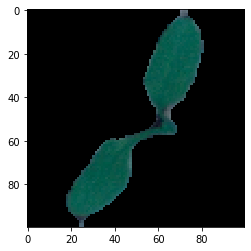

In [0]:
plt.imshow(X_train[600])

**Define input_shape & number of classes:**

In [0]:
input_shape = (100, 100, 3)
num_classses = 12

**Building the model:**

In [0]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), input_shape=input_shape, activation='relu'))   # Convolution layer
model.add(tf.keras.layers.BatchNormalization(axis=3))                                                           # Batch Normalization
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))                            # Convolution layer
model.add(tf.keras.layers.MaxPooling2D((2, 2)))                                                                 # Pooling layer
model.add(tf.keras.layers.BatchNormalization(axis=3))                                                           # Batch Normalization
model.add(tf.keras.layers.Dropout(0.1))                                                                         # Dropout layer

model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(tf.keras.layers.BatchNormalization(axis=3))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization(axis=3))
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(tf.keras.layers.BatchNormalization(axis=3))
model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization(axis=3))
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Flatten())                                                                            # Flatten data before giving to ANN

model.add(tf.keras.layers.Dense(256, activation='relu'))                                                        # Dense layer
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))                                             # Output layer

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 96, 96, 64)        4864      
_________________________________________________________________
batch_normalization_64 (Batc (None, 96, 96, 64)        256       
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 92, 92, 64)        102464    
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 46, 46, 64)        0         
_________________________________________________________________
batch_normalization_65 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
dropout_31 (Dropout)         (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 42, 42, 128)      

## **Execute the model:**

In [0]:
# Reduce learning rate when a metric has stopped improving. Here we monitor accuracy
lrr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# Save the best model after every epoch. Since accuracy is monitored, we give mode as max
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/CNN/plant-seedlings-classification/model.h5', monitor='accuracy', 
                              verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint, lrr]

# Fit the model:
model.fit_generator(generator.flow(X_train, y_train, batch_size=64), 
                           epochs=40, validation_data=(X_test, y_test), 
                           steps_per_epoch=X_train.shape[0] // 64 , callbacks=callbacks_list)

  ...
    to  
  ['...']
Train for 66 steps, validate on 475 samples
Epoch 1/40
65/66 [============================>.] - ETA: 0s - loss: 0.2420 - accuracy: 0.9079
Epoch 00001: accuracy improved from -inf to 0.90691, saving model to /content/drive/My Drive/CNN/plant-seedlings-classification/model.h5
66/66 [==============================] - 17s 261ms/step - loss: 0.2437 - accuracy: 0.9069 - val_loss: 0.3614 - val_accuracy: 0.8505
Epoch 2/40
65/66 [============================>.] - ETA: 0s - loss: 0.2489 - accuracy: 0.9048
Epoch 00002: accuracy did not improve from 0.90691
66/66 [==============================] - 13s 193ms/step - loss: 0.2492 - accuracy: 0.9050 - val_loss: 0.2993 - val_accuracy: 0.8989
Epoch 3/40
65/66 [============================>.] - ETA: 0s - loss: 0.2311 - accuracy: 0.9129
Epoch 00003: accuracy improved from 0.90691 to 0.91356, saving model to /content/drive/My Drive/CNN/plant-seedlings-classification/model.h5
66/66 [==============================] - 13s 204ms/step -

## **Evaluate the model on test data:**

In [0]:
final_model = tf.keras.models.load_model('/content/drive/My Drive/CNN/plant-seedlings-classification/model.h5')
final_loss, final_accuracy = final_model.evaluate(X_test, y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

475/475 [==============================] - 1s 1ms/sample - loss: 0.2731 - accuracy: 0.9158
Final Loss: 0.2731436230634388, Final Accuracy: 0.9157894849777222


## **Confusion Matrix:**

In [0]:
y_pred = final_model.predict_classes(X_test)

cm = confusion_matrix(y_test.argmax(axis=1), y_pred)
print('Confusion matrix: \n', cm)

Confusion matrix: 
 [[20  2  0  0  0  0  0  1  0  0  0  0]
 [ 0 50  0  1  0  0  0  0  1  0  0  0]
 [ 0  0 38  0  0  0  0  1  0  0  0  0]
 [ 0  0  0 21  1  0  0  0  0  0  0  0]
 [ 0  0  0  0 58  0  1  1  0  0  0  5]
 [ 0  0  0  0  1 49  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 20  0  0  0  0  2]
 [ 0  0  0  1  0  0  0 46  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 61  0  0  0]
 [ 0  0  0  0  0  1  0  0  1 26  1  0]
 [ 0  0  0  0  0  0  0  0  0  0 39  0]
 [ 0  0  0  2 15  0  2  0  0  0  0  7]]


**Let's plot the confusion matrix for better understanding:**

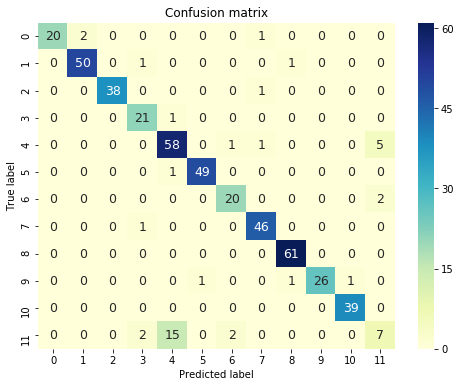

In [0]:
plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(cm), annot=True, annot_kws={"fontsize":12.5}, cmap='YlGnBu', fmt='d')
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Classification Report:**

In [0]:
print(classification_report(y_test.argmax(axis=1), y_pred))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93        23
           1       0.96      0.96      0.96        52
           2       1.00      0.97      0.99        39
           3       0.84      0.95      0.89        22
           4       0.77      0.89      0.83        65
           5       0.98      0.98      0.98        50
           6       0.87      0.91      0.89        22
           7       0.94      0.98      0.96        47
           8       0.97      1.00      0.98        61
           9       1.00      0.90      0.95        29
          10       0.97      1.00      0.99        39
          11       0.50      0.27      0.35        26

    accuracy                           0.92       475
   macro avg       0.90      0.89      0.89       475
weighted avg       0.91      0.92      0.91       475



**Inference from Confusion matrix and Classification Report:**

In [15]:
plants_df['Plant_Species_name']

0               Shepherds Purse
1             Scentless Mayweed
2                    Sugar beet
3                         Maize
4              Loose Silky-bent
5     Small-flowered Cranesbill
6                  Common wheat
7                       Fat Hen
8              Common Chickweed
9                      Cleavers
10                     Charlock
11                  Black-grass
Name: Plant_Species_name, dtype: object

- As seen, Sugar beet and Charlock are classified the most 
- Followed by Small-flowered Cranesbill & Common Chickweed
- Black-grass has been incorrectly predicted as Loose Silky-bent many a times and the reverse has happened quite a few times

**Let's view Loose Silky-bent & Black-grass:**

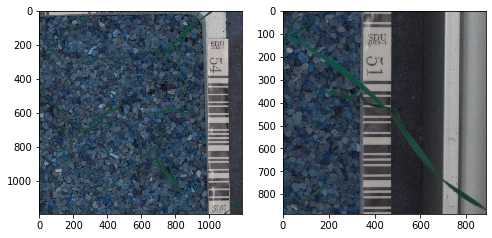

In [39]:
tmp = ' '
disp_data = []

for category in list(plants_df.iloc[[4,11]]['Plant_Species_name'].values):
    path = os.path.join(train_data_folder, category)
    for img in os.listdir(path):
      if category != tmp:
        n_img = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)  # image read
        disp_data.append([n_img, category]) 
      tmp = category                         
        
fig, axs = plt.subplots(1, 2, figsize=(8, 6))
axs[0].imshow(disp_data[0][0])  # Loose Silky-bent'
axs[1].imshow(disp_data[1][0])  # Black-grass'

As seen in the pics, these plant types (Loose Silky-bent & Black-grass) look similar and hence our model had difficulties in classifying them correctly.

## **Overall Summary:**

- Loaded the train dataset folder and read the images and assigned the species for each image
- Preprocessed the data to remove background noise and also sharpened the image
- Resized all the images so as to be consistent before feeding them to the model
- Splitted the data into 90:10 ratio 
- Built a CNN model and trained it after image augumentation, with a batch size of 64 and epoch of 40
- Validated our model against the validation data set and it gave an accuracy of 92%
- Confusion matrix was plotted 
- Classification report was generated.

### <center> **End of CNN_Plants_seedlingd_classification assignment** </center>